# Reproducibility meets randomness

Ensuring reproducibility in computational social science experiments when randomness is involved is crucial. This tutorial will cover various topics on reproducibility in Python programs incorporating randomness, primarily focusing on NumPy. We will use the following modules and libraries through the tutorial.

In [1]:
import numpy as np
import sys, os
import pickle
from matplotlib import pyplot as plt
from scipy.stats import binom

## Random states in NumPy

We first look at a simple example of experiment where randomness is involved. In this example we generate an [Erdős-Rényi graph](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model) with the number of nodes $n$ and the probability of edge creation $p$.

In [2]:
# Parameters
n = 1000  # Number of nodes
p = 0.2   # Probability of edge creation

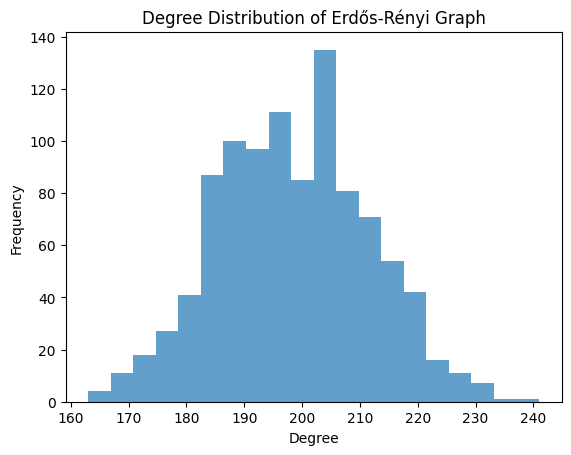

In [3]:
# Generate upper triangular part of adjacency matrix
upper_triangular = np.triu(np.random.rand(n, n) < p, k=1)

# Ensure symmetry by setting upper triangular part equal to lower triangular part
A = upper_triangular + upper_triangular.T

# Plot degree distribution
degrees = np.sum(A, axis=0)
plt.hist(degrees, bins=20, alpha=0.7)
plt.title('Degree Distribution of Erdős-Rényi Graph')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

Now we try to reproduce the result with the same code.

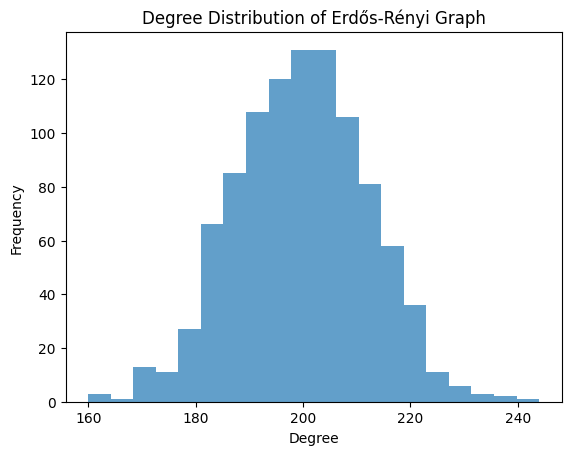

In [4]:
# Generate upper triangular part of adjacency matrix
upper_triangular = np.triu(np.random.rand(n, n) < p, k=1)

# Ensure symmetry by setting upper triangular part equal to lower triangular part
A = upper_triangular + upper_triangular.T

# Plot degree distribution
degrees = np.sum(A, axis=0)
plt.hist(degrees, bins=20, alpha=0.7)
plt.title('Degree Distribution of Erdős-Rényi Graph')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

We notice that the results are different for the two executions. This is because ```np.random.rand(n, n)``` generates different random values each time.

To reproduce the exact result, it is necessary to use the same random state for each execution. The random state refers to the complete state of the random number generator at a certain point in time. It includes all the information needed to reproduce the sequence of random numbers generated by the generator.

* ```random_state = np.random.get_state()``` retrieves the current state of the NumPy random number generator and stores it in the variable ```random_state```;
* ```np.random.set_state(random_state)``` sets the NumPy random state to the one in the specified```random_state``` variable.

For example:

In [5]:
# first execution, random state is saved:
random_state = np.random.get_state()
print(np.random.rand(5))

[0.74217434 0.98190907 0.56635331 0.17249818 0.70473361]


In [6]:
# second execution, saved random state is not loaded:
print(np.random.rand(5))

[0.21189736 0.40670284 0.03071464 0.45978797 0.43281128]


In [7]:
# third execution, saved random state is loaded:
np.random.set_state(random_state)
print(np.random.rand(5))

[0.74217434 0.98190907 0.56635331 0.17249818 0.70473361]


As we have seen, only by setting the same random state using ```np.random.set_state()```, can we ensure that the random numbers generated by NumPy are reproducible.

It is important to note that other libraries and functions might also use random number generators internally. Thus, it is important to set the random states for those as well if we want reproducibility across your entire codebase.

## Preserving the random state

In this section we demonstrate a technique to save and load the random state for NumPy's random number generator. 

```Python
# save / load random state
f_random_state = 'sim-network-random_state.pickle'
force_rebuild = False

if os.path.isfile(f_random_state) and not force_rebuild:
    # reproduce
    with open(f_random_state, 'rb') as f:
        random_state = pickle.load(f)
    np.random.set_state(random_state)
else:
    # produce
    random_state = np.random.get_state()
    with open(f_random_state, 'wb') as f:
        pickle.dump(random_state, f)
```

Here's an explanation:

* ```f_random_state``` stores the file path where the random state will be saved or loaded from. This is set to ```sim-network-random_state.pickle```.

* ```force_rebuild``` is a boolean variable that controls whether to force the code to rebuild the random state or load it from a saved file. If ```force_rebuild``` is True, the code will rebuild the random state; otherwise, it will attempt to load it from the saved file.

The code then checks if the file containing the random state exists (```os.path.isfile(f_random_state)```) and whether the code is not forced to rebuild the random state (```not force_rebuild```).

* If the saved random state file exists and ```force_rebuild``` is set to False, we are reproducing the result in a previous experiment in which the random state was saved. The code loads the random state from the file using ```pickle.load(f)```. ```pickle``` is a Python module used for serializing and deserializing Python objects.
The loaded random state is then set using ```np.random.set_state(random_state)```. This ensures that the random number generator will produce the same sequence of random numbers as it did when the state was saved.

* If the saved random state file does not exist or if ```force_rebuild``` is True, we are conducting a new experiment and wish to save the random state in order to reproduce the result later.The code generates a new random state using ```np.random.get_state()```. The generated random state is then saved to the file using ```pickle.dump(random_state, f)```.

Now, we use this technique to reproduce the degree distribution of the Erdős-Rényi graph in a previous experiment, in which the NumPy random state was saved to ```sim-network-random_state.pickle```.

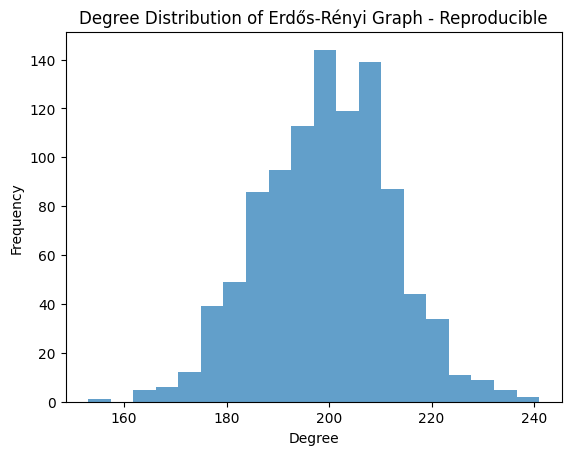

In [8]:
# save / load random state
f_random_state = 'sim-network-random_state.pickle'
force_rebuild = False

if os.path.isfile(f_random_state) and not force_rebuild:
    # reproduce
    with open(f_random_state, 'rb') as f:
        random_state = pickle.load(f)
    np.random.set_state(random_state)
else:
    # produce
    random_state = np.random.get_state()
    with open(f_random_state, 'wb') as f:
        pickle.dump(random_state, f)

# execution of this line of code breaks reproducibility
#np.random.rand(100)

# execution of this line of code does not break reproducibility
#print('Execution of this line of code does not break reproducibility.')

# Generate upper triangular part of adjacency matrix
upper_triangular = np.triu(np.random.rand(n, n) < p, k=1)

# Ensure symmetry by setting upper triangular part equal to lower triangular part
A = upper_triangular + upper_triangular.T

# Plot degree distribution
degrees = np.sum(A, axis=0)
plt.hist(degrees, bins=20, alpha=0.7)
plt.title('Degree Distribution of Erdős-Rényi Graph - Reproducible')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

The reproduced plot and the result of the previous experiment saved in the file ```sim-degree-distribution.pdf``` ([click here to show](sim-degree-distribution.pdf)) should be the same.

It is also important to notice that adding instructions that generate random numbers using ```np.random``` before ```upper_triangular = np.triu(np.random.rand(n, n) < p, k=1)``` breaks reproducibility. Thus, we should be careful when we add instructions or change the execution order. In such cases, it is recommended to rerun the experiment using a new random state. To do so, simply delete the file ```sim-network-random_state.pickle```, or set ```false_rebuild = True```.

## Avoid cherry-picking results

When the random state is set to a specific value, the execution of the experiment becomes deterministic. While this is good for reproducibility, it somehow defeats the purpose of having randomness, and can run into the risk of drawing a conclusion based on outliers or cherry-picked results. To balance the need for reproducibility with the desire to incorporate randomness, one approach is to conduct multiple runs of the experiment and analyze the distribution of results. This allows you to assess the variability of the outcomes and draw more robust conclusions.

Getting back to our example, we first generate multiple instances of Erdős-Rényi graphs and store the degree vectors of all graphs.

In [9]:
n_iter = 1000  # number of iterations
degrees_all = np.zeros((n, n_iter))  # preallocate an array to store the degrees of nodes for each iteration

for i in range(n_iter):
    # Generate upper triangular part of adjacency matrix
    upper_triangular = np.triu(np.random.rand(n, n) < p, k=1)
    
    # Ensure symmetry by setting upper triangular part equal to lower triangular part
    A = upper_triangular + upper_triangular.T

    # Compute degrees
    degrees_all[:, i] = np.sum(A, axis=0)

Next, we use the to plot the average degree distribution with an error bar representing the standard deviation. We also plot the theoretical degree distribution of the Erdős-Rényi model as comparison.

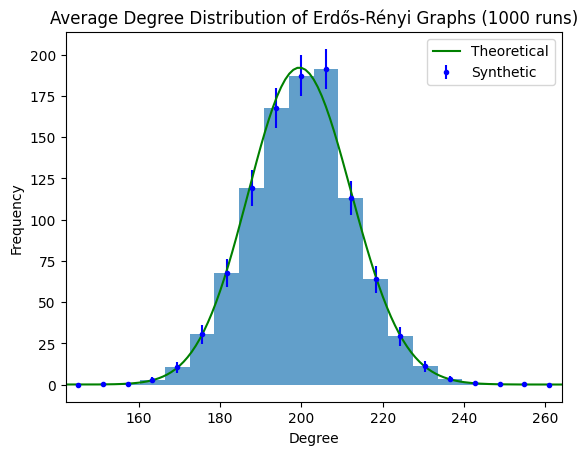

In [10]:
n_bins = 20
bins = np.linspace(np.min(degrees_all), np.max(degrees_all), num=n_bins+1)

degrees_hist = np.zeros((n_bins, n_iter))   # preallocate an array to store the histogram for each iteration
for i in range(n_iter):
    # Calculate histogram and append to degrees_hist
    hist, _ = np.histogram(degrees_all[:, i], bins=bins)
    degrees_hist[:, i] = hist
    
# Calculate average histogram and standard deviation
avg_hist = np.mean(degrees_hist, axis=1)
std_hist = np.std(degrees_hist, axis=1)
bin_centers = (bins[1:] + bins[:-1]) / 2

# Plot average degree distribution
plt.bar(bin_centers, avg_hist, width=np.diff(bins), alpha=0.7)
plt.errorbar(bin_centers, avg_hist, yerr=std_hist, fmt='.', label='Synthetic', color='b')

# Plot theoretical degree distribution
theoretical_degrees = binom.pmf(np.arange(n), n-1, p) * (n-1)
plt.plot(np.arange(n), theoretical_degrees*(bins[1]- bins[0]), label='Theoretical', color='g')

plt.title(f'Average Degree Distribution of Erdős-Rényi Graphs ({n_iter} runs)')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.xlim([bins[0], bins[-1]])
plt.legend()
plt.show()